### Visualizing Action Classes Learned with RGB Flow Models

This notebook is adapted from the original DeepDraw notebook. In particular, this notebook generates RGB images from action recognition models trained on RGB frames. The output is a image refelecting the knowledge in the model of a specific action class.

------


This is an ipython notebook to generate visualizations of classes with GoogLeNet, for some more info refer to [this blogpost](http://auduno.com/post/125362849838/visualizing-googlenet-classes), and for some examples of generated images see [this](https://goo.gl/photos/8qcvjnYBQVSGG2eN6) album of highlights or [this](https://goo.gl/photos/FfsZZektqpZkdDnKA) album of all 1000 imagenet classes.

To run this code, you'll need an installation of Caffe with built pycaffe libraries, as well as the python libraries numpy, scipy and PIL. For instructions on how to install Caffe and pycaffe, refer to the installation guide [here](http://caffe.berkeleyvision.org/installation.html). Before running the ipython notebooks, you'll also need to download the [bvlc_googlenet model](https://github.com/BVLC/caffe/tree/master/models/bvlc_googlenet), and modify the variables ```pycaffe_root``` to refer to the path of your pycaffe installation (if it's not already in your python path) and ```model_path``` to refer to the path of the googlenet caffe model. Also uncomment the line that enables GPU mode if you have built Caffe with GPU-support and a suitable GPU available.


In [1]:
caffe_path = '/path/to/caffe_root'
tsn_path = '/path/to/tsn'
save_path = ''
# which action class to visualize (0-based), to view the class name, see <tsn_path>/data/ucf101_splits/classInd.txt
action_class = 48

In [2]:
# imports and basic notebook setup
from cStringIO import StringIO
import numpy as np
import os,re,random
import scipy.ndimage as nd
import PIL.Image
import sys
from IPython.display import clear_output, Image, display
from scipy.misc import imresize

pycaffe_root = caffe_path+"/python" 
sys.path.insert(0, pycaffe_root)
import caffe

model_name = "TSN-BN-Inception-RGB"
net_fn   = './tsn_bn_inception_rgb_deploy.prototxt'
param_fn = tsn_path+'models/ucf101_split1_tsn_rgb_reference_bn_inception.caffemodel'
mean = np.float32([104.0, 117.0, 123.0])

caffe.set_mode_gpu() # uncomment this if gpu processing is available
caffe.set_device(0)
net = caffe.Classifier(net_fn, param_fn,
                       mean = mean, # ImageNet mean, training set dependent
                       channel_swap = (2,1,0)) # the reference model has channels in BGR order instead of RGB

# a couple of utility functions for converting to and from Caffe's input image layout
def preprocess(net, img):
    return np.float32(np.rollaxis(img, 2)[::-1]) - net.transformer.mean['data']
def deprocess(net, img):
    return np.dstack((img + net.transformer.mean['data'])[::-1])

def blur(img, sigma):
    if sigma > 0:
        img[0] = nd.filters.gaussian_filter(img[0], sigma, order=0)
        img[1] = nd.filters.gaussian_filter(img[1], sigma, order=0)
        img[2] = nd.filters.gaussian_filter(img[2], sigma, order=0)
    return img

def showarray(a, f, fmt='jpeg'):
    a = np.uint8(np.clip(a, 0, 255))
    f = StringIO()
    PIL.Image.fromarray(a).save(f, fmt)
    display(Image(data=f.getvalue()))

Definition of the main gradient ascent functions. Note that these are based on the [deepdream code](https://github.com/google/deepdream/blob/master/dream.ipynb) published by Google as well as [this code](https://github.com/kylemcdonald/deepdream/blob/master/dream.ipynb) by Kyle McDonald.

In [3]:
def make_step(net, step_size=1.5, end='inception_4c/output', clip=True, focus=None, sigma=None):
    '''Basic gradient ascent step.'''

    src = net.blobs['data'] # input image is stored in Net's 'data' blob
    
    dst = net.blobs[end]
    net.forward(end=end)

    one_hot = np.zeros_like(dst.data)
    one_hot.flat[focus] = 1.
    dst.diff[:] = one_hot

    net.backward(start=end)
    g = src.diff[0]
    
    src.data[:] += step_size/np.abs(g).mean() * g

    if clip:
        bias = net.transformer.mean['data']
        src.data[:] = np.clip(src.data, -bias, 255-bias) 
        
    src.data[0] = blur(src.data[0], sigma)
    
    # reset objective for next step
    dst.diff.fill(0.)

def deepdraw(net, base_img, octaves, random_crop=True, visualize=True, focus=None,
    clip=True, **step_params):
    
    # prepare base image
    image = preprocess(net, base_img) # (3,224,224)

    # get input dimensions from net
    w = net.blobs['data'].width
    h = net.blobs['data'].height
    
    print "starting drawing"
    src = net.blobs['data']
    src.reshape(1,3,h,w) # resize the network's input image size
    for e,o in enumerate(octaves):
        if 'scale' in o:
            # resize by o['scale'] if it exists
            image = nd.zoom(image, (1,o['scale'],o['scale']))
        _,imw,imh = image.shape
        
        # select layer
        layer = o['layer']

        for i in xrange(o['iter_n']):
            if imw > w:
                if random_crop:
                    # randomly select a crop 
                    #ox = random.randint(0,imw-224)
                    #oy = random.randint(0,imh-224)
                    mid_x = (imw-w)/2.
                    width_x = imw-w
                    ox = np.random.normal(mid_x, width_x*0.3, 1)
                    ox = int(np.clip(ox,0,imw-w))
                    mid_y = (imh-h)/2.
                    width_y = imh-h
                    oy = np.random.normal(mid_y, width_y*0.3, 1)
                    oy = int(np.clip(oy,0,imh-h))
                    # insert the crop into src.data[0]
                    src.data[0] = image[:,ox:ox+w,oy:oy+h]
                else:
                    ox = (imw-w)/2.
                    oy = (imh-h)/2.
                    src.data[0] = image[:,ox:ox+w,oy:oy+h]
            else:
                ox = 0
                oy = 0
                src.data[0] = image.copy()
                
            sigma = o['start_sigma'] + ((o['end_sigma'] - o['start_sigma']) * i) / o['iter_n']
            step_size = o['start_step_size'] + ((o['end_step_size'] - o['start_step_size']) * i) / o['iter_n']
            
            make_step(net, end=layer, clip=clip, focus=focus, 
                      sigma=sigma, step_size=step_size)

            if visualize:
                vis = deprocess(net, src.data[0])
                if not clip: # adjust image contrast if clipping is disabled
                    vis = vis*(255.0/np.percentile(vis, 99.98))
                if i % 1 == 0:
                    showarray(vis,"./filename"+str(i)+".jpg")
            
            if i % 50 == 0 or i ==o['iter_n']-1:
                print 'finished step %d in octave %d' % (i,e)
            
            # insert modified image back into original image (if necessary)
            image[:,ox:ox+w,oy:oy+h] = src.data[0]
        
        print "octave %d image:" % e
        
        showarray(deprocess(net, image),"./octave_"+str(e)+".jpg")
            
    # returning the resulting image
    return deprocess(net, image)

#### Generating the class visualizations

The ```octaves``` list determines in which order we optimize layers, as well as how many iterations and scaling on each octave. For each octave, parameters are:
* ```layer``` : which layer to optimize
* ```iter_n``` : how many iterations
* ```scale``` : by what factor (if any) to scale up the base image before proceeding
* ```start_sigma``` : the initial radius of the gaussian blur
* ```end_sigma``` : the final radius of the gaussian blur
* ```start_step_size``` : the initial step size of the gradient ascent
* ```end_step_size``` : the final step size of the gradient ascent

The choice of octave parameters below will give decent images, and is the one used for visualizations in the blogpost. However, the choice of parameters was a bit arbitrary, so feel free to experiment. Note that generating an image will take around 1 minute with GPU-enabled Caffe, or 10-15 minutes if you're running purely on CPU, depending on your computer performance.

starting drawing
finished step 0 in octave 0
finished step 50 in octave 0
finished step 100 in octave 0
finished step 150 in octave 0
finished step 189 in octave 0
octave 0 image:


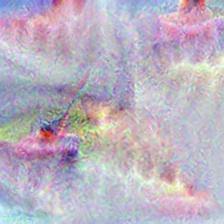

finished step 0 in octave 1
finished step 50 in octave 1
finished step 100 in octave 1
finished step 149 in octave 1
octave 1 image:


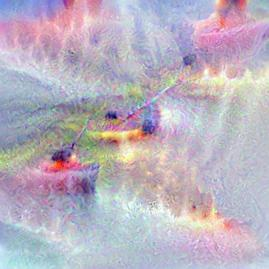

finished step 0 in octave 2
finished step 50 in octave 2
finished step 100 in octave 2
finished step 149 in octave 2
octave 2 image:


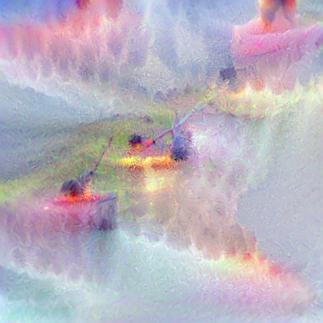

finished step 0 in octave 3
finished step 9 in octave 3
octave 3 image:


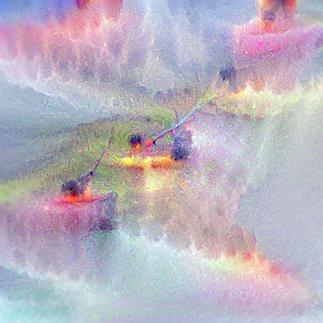

In [5]:
# these octaves determine gradient ascent steps
octaves = [
    {
        'layer':'fc-action',
        'iter_n':190,
        'start_sigma':2.5,
        'end_sigma':0.78,
        'start_step_size':11.,
        'end_step_size':11.
    },
    {
        'layer':'fc-action',
        'scale':1.2,
        'iter_n':150,
        'start_sigma':0.78*1.2,
        'end_sigma':0.5,
        'start_step_size':6.,
        'end_step_size':6.
    },
    {
        'layer':'fc-action',
        'scale':1.2,
        'iter_n':150,
        'start_sigma':0.78*1.2,
        'end_sigma':0.44,
        'start_step_size':6.,
        'end_step_size':3.
    },
    {
        'layer':'fc-action',
        'iter_n':10,
        'start_sigma':0.44,
        'end_sigma':0.304,
        'start_step_size':3.,
        'end_step_size':3.
    }
]

# get original input size of network
original_w = net.blobs['data'].width
original_h = net.blobs['data'].height
# the background color of the initial image
background_color = np.float32([200.0, 200.0, 200.0])
# generate initial random image
gen_image = np.random.normal(background_color, 12, (original_w, original_h, 3))



# generate class visualization via octavewise gradient ascent
gen_image = deepdraw(net, gen_image, octaves, focus=action_class, 
                 random_crop=True, visualize=False)

# save image
import os
img_fn = os.path.join(save_path, '_'.join(["tsn_visualization_rgb", str(action_class)+'.png']))
PIL.Image.fromarray(np.uint8(gen_image)).save(img_fn)